In [ ]:
from google.colab import drive
!rm -rf /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import load_model

In [ ]:
file_path = '/content/drive/MyDrive/Delhi (potato) dataset.xlsx'
data = pd.read_excel(file_path)
print(data.head())
numeric_columns = data.select_dtypes(include='number').columns.tolist()
print("Numeric columns:", numeric_columns)

  Price Date  Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
0 2010-09-21                    450.0                   1400.0   
1 2010-09-22                    450.0                   1400.0   
2 2010-09-23                    500.0                   1400.0   
3 2010-09-24                    500.0                   1400.0   
4 2010-09-25                    500.0                   1400.0   

   Modal Price (Rs./Quintal)  
0                      884.0  
1                      909.0  
2                      921.0  
3                      926.0  
4                      969.0  
Numeric columns: ['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']


In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

Price Date                     0
Min Price (Rs./Quintal)      944
Max Price (Rs./Quintal)      944
Modal Price (Rs./Quintal)      0
dtype: int64


### **Feature Engineering(Time split and Seasonal Indicators)**

In [ ]:
data['Day of Week'] = pd.to_datetime(data['Price Date']).dt.dayofweek
data['Month'] = pd.to_datetime(data['Price Date']).dt.month
data['Quarter'] = pd.to_datetime(data['Price Date']).dt.quarter
data['Year'] = pd.to_datetime(data['Price Date']).dt.year

In [ ]:
data['7-Day Rolling Mean'] = data['Modal Price (Rs./Quintal)'].rolling(window=7).mean()
data['30-Day Rolling Mean'] = data['Modal Price (Rs./Quintal)'].rolling(window=30).mean()

In [ ]:
data['Price Change'] = data['Modal Price (Rs./Quintal)'].diff()

### **Scaling Numeric Columns**

In [ ]:
scaler = MinMaxScaler()
numeric_columns = ['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)', 'Price Change']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [ ]:
print(data.isnull().sum())
data.fillna(method='ffill', inplace=True)

Price Date                     0
Min Price (Rs./Quintal)      944
Max Price (Rs./Quintal)      944
Modal Price (Rs./Quintal)      0
Day of Week                    0
Month                          0
Quarter                        0
Year                           0
7-Day Rolling Mean             6
30-Day Rolling Mean           29
Price Change                   1
dtype: int64


<ipython-input-14-c0b246ac362a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
columns_order = ['Price Date', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)',
                 'Price Change', '7-Day Rolling Mean', '30-Day Rolling Mean', 'Day of Week', 'Month', 'Quarter', 'Year']
data = data[columns_order]

In [ ]:
output_file_path = '/content/drive/MyDrive/preproccesed_potato(delhi)_dataset.xlsx'
data.to_excel(output_file_path, index=False)

### **Exploratory Data Analysis (EDA):**

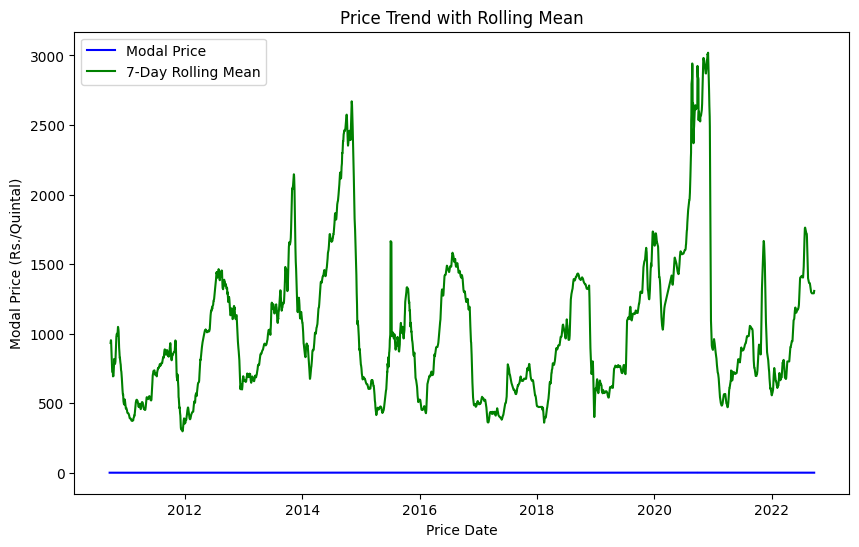

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Price Date', y='Modal Price (Rs./Quintal)',color='blue', label='Modal Price')
sns.lineplot(data=data, x='Price Date', y='7-Day Rolling Mean',color='green', label='7-Day Rolling Mean')
plt.title('Price Trend with Rolling Mean')
plt.show()

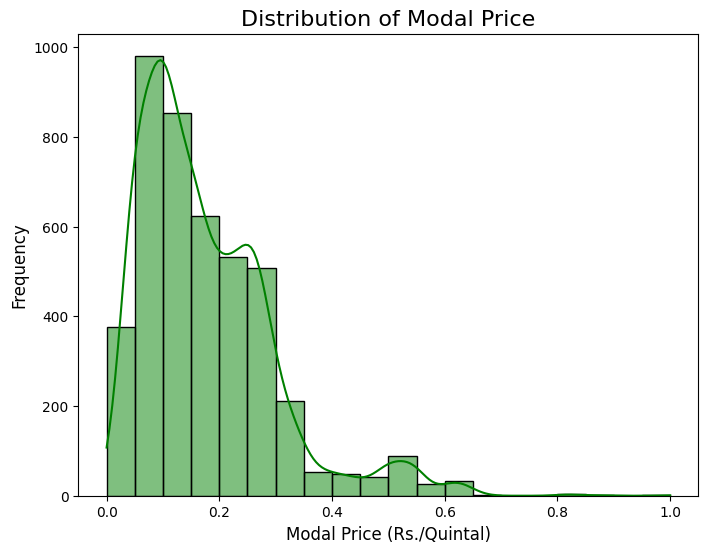

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data['Modal Price (Rs./Quintal)'], bins=20, color='green', kde=True)
plt.title('Distribution of Modal Price', fontsize=16)
plt.xlabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

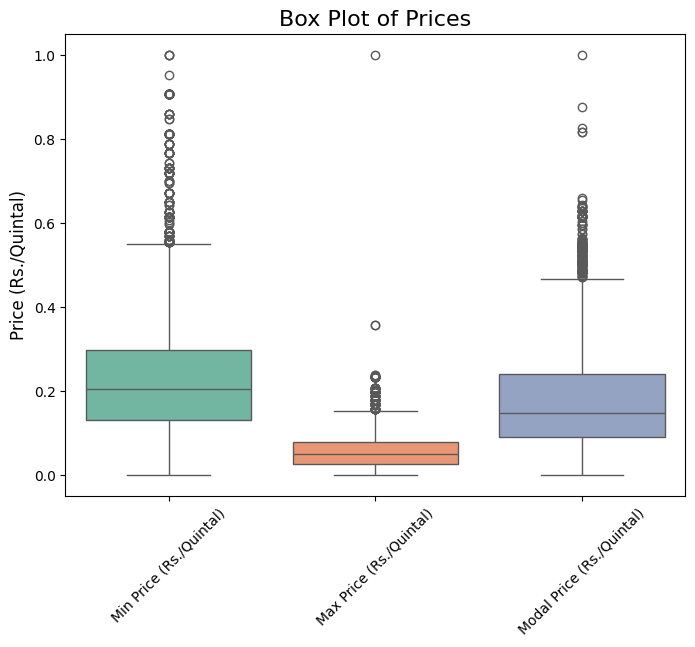

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']], palette='Set2')
plt.title('Box Plot of Prices', fontsize=16)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

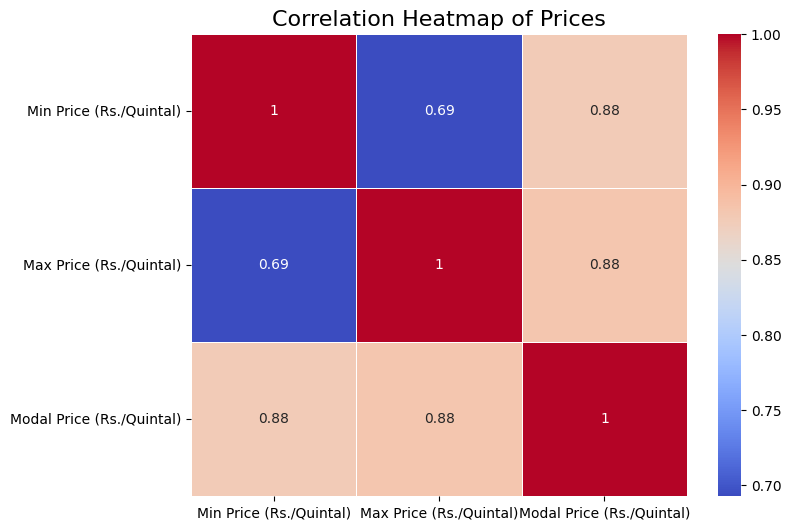

In [ ]:
plt.figure(figsize=(8,6))
corr = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Prices', fontsize=16)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been as

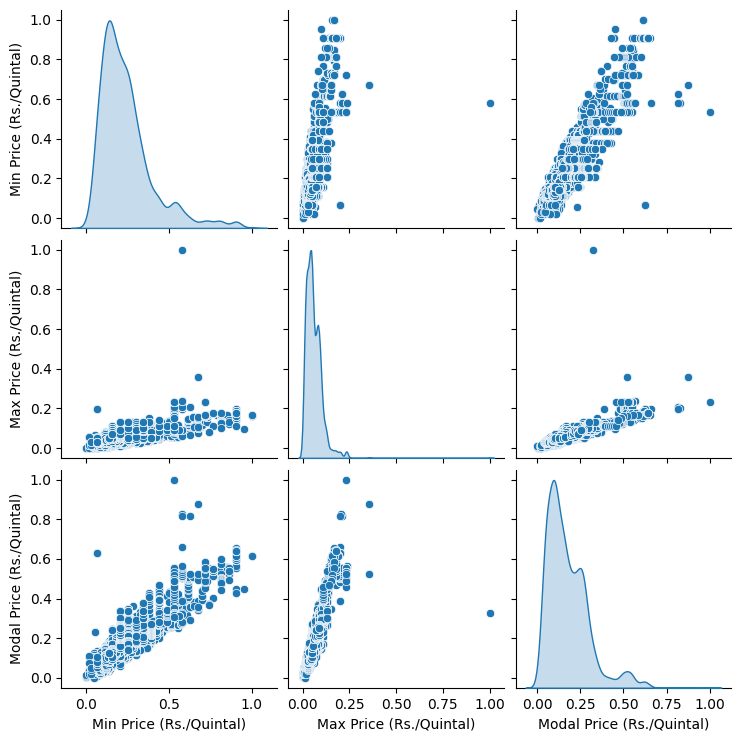

In [ ]:
sns.pairplot(data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']], diag_kind='kde', palette='husl')
plt.show()

### **LSTM model**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
features = data[['Modal Price (Rs./Quintal)']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_data, columns=['Scaled Modal Price'])

In [ ]:
window_size = 30

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data.iloc[i-window_size:i, 0])
    y.append(scaled_data.iloc[i, 0])

X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### **Training**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 8.6633e-04 - val_loss: 0.0015
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 6.6765e-04 - val_loss: 0.0014
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 6.6539e-04 - val_loss: 0.0013
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 5.8412e-04 - val_loss: 0.0013
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 5.5985e-04 - val_loss: 0.0014
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 4.6703e-04 - val_loss: 0.0012
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.6392e-04 - val_loss: 0.0014
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 5.3663e-04 - val_loss: 0.0012
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.0483e-04 - val_loss: 0.0012
Epoch

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - mae: 0.0188
Test Loss: 0.0015975394053384662, Test MAE: 0.013972393237054348


In [ ]:
predicted_prices = model.predict(X)

predicted_prices = scaler.inverse_transform(predicted_prices)

predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted Modal Price'])

137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step


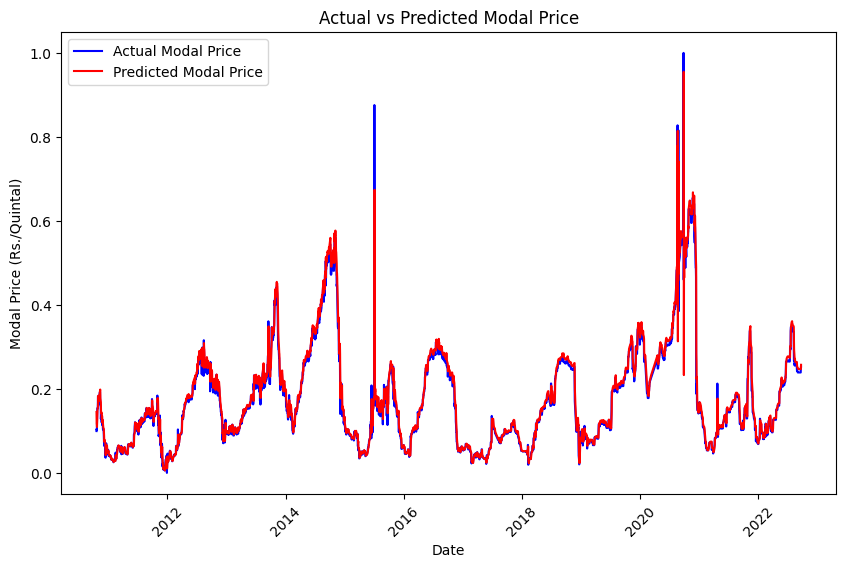

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(data['Price Date'][-len(predicted_prices):], features[-len(predicted_prices):], color='blue', label='Actual Modal Price')
plt.plot(data['Price Date'][-len(predicted_prices):], predicted_prices, color='red', label='Predicted Modal Price')
plt.title('Actual vs Predicted Modal Price')
plt.xlabel('Date')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/lstm_potato_price_model.h5')

In [ ]:
predicted_scaled_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_scaled_prices)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
predicted_prices = model.predict(X)

predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Mean Squared Error (MSE): 0.0005613903706749088
Mean Absolute Error (MAE): 0.00945924930220678


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(actual_prices, predicted_prices)
print(f'R-Squared: {r2}')

R-Squared: 0.9617408067970677


In [ ]:
model = load_model('/content/drive/MyDrive/lstm_potato_price_model.h5')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

model = load_model('/content/drive/MyDrive/lstm_potato_price_model.h5')

data = pd.read_excel('/content/drive/MyDrive/preproccesed_potato(delhi)_dataset.xlsx')
data['Price Date'] = pd.to_datetime(data['Price Date'])

def predict_price(date):
    date = pd.to_datetime(date)

    if date < data['Price Date'].min() or date > data['Price Date'].max():
        return "Date out of range"
    filtered_data = data[data['Price Date'] <= date]
    if len(filtered_data) < 30:
        return "Not enough data for prediction"
    last_30_days = filtered_data.tail(30)[['Modal Price (Rs./Quintal)']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_last_30_days = scaler.fit_transform(last_30_days)
    X_new = []
    X_new.append(scaled_last_30_days)

    X_new = np.array(X_new)
    X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))
    predicted_price_scaled = model.predict(X_new)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    return predicted_price[0][0]

date_to_predict = '2022-05-20'  # Replace with your desired date
predicted_price = predict_price(date_to_predict)
if isinstance(predicted_price, (int, float)):
    print(f'Predicted Price on {date_to_predict}: {predicted_price:.2f} Rs./Quintal')
else:
    print(f'Prediction for {date_to_predict}: {predicted_price*100} Rs./kg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Prediction for 2022-05-20: 19.947712123394012 Rs./kg


In [ ]:
model = load_model('/content/drive/MyDrive/lstm_potato_price_model.h5')

data = pd.read_excel('/content/drive/MyDrive/preproccesed_potato(delhi)_dataset.xlsx')
data['Price Date'] = pd.to_datetime(data['Price Date'])

def predict_future_prices(num_predictions):
    last_data = data.tail(30)[['Modal Price (Rs./Quintal)']]
    scaled_last_data = scaler.transform(last_data)

    input_sequence = []
    input_sequence.append(scaled_last_data)
    input_sequence = np.array(input_sequence)
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[0], input_sequence.shape[1], 1))

    future_prices = []

    for _ in range(num_predictions):
        predicted_price_scaled = model.predict(input_sequence)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        future_prices.append(predicted_price[0][0])

        new_input = np.append(scaled_last_data, predicted_price_scaled, axis=0)[1:]
        input_sequence = np.array([new_input])
        input_sequence = np.reshape(input_sequence, (input_sequence.shape[0], input_sequence.shape[1], 1))

    return future_prices

# Example usage
num_future_predictions = 10
predicted_future_prices = predict_future_prices(num_future_predictions)

# Display the results
for i, price in enumerate(predicted_future_prices):
    if isinstance(predicted_price, (int, float)):
      print(f'Predicted Price on {date_to_predict}: {predicted_price:.2f} Rs./Quintal')
    else:
        print(f'Prediction for {date_to_predict}: {predicted_price*100} Rs./Quintal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal
Prediction for 2021-09-20: 101.79352760314941 Rs./Quintal


In [ ]:
model = load_model('/content/drive/MyDrive/lstm_potato_price_model.h5')

data = pd.read_excel('/content/drive/MyDrive/preproccesed_potato(delhi)_dataset.xlsx')
data['Price Date'] = pd.to_datetime(data['Price Date'])

def predict_prices_for_dates(future_dates):
    predictions = []

    last_data = data.tail(30)[['Modal Price (Rs./Quintal)']].values
    input_sequence = last_data.reshape((1, last_data.shape[0], 1))

    for future_date in future_dates:
        predicted_price = model.predict(input_sequence)
        predictions.append(predicted_price[0][0])

        new_input = np.append(input_sequence[0, :, 0], predicted_price)
        input_sequence = new_input[-30:].reshape((1, 30, 1))

    return predictions

future_dates = pd.to_datetime(['2030-12-31', '2030-12-04', '2030-12-15'])
predicted_prices = predict_prices_for_dates(future_dates)

for date, price in zip(future_dates, predicted_prices):
    print(f'Predicted Price on {date.date()}: {(price*100):.2f} Rs./kg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Price on 2030-12-31: 25.83 Rs./kg
Predicted Price on 2030-12-04: 26.40 Rs./kg
Predicted Price on 2030-12-15: 26.91 Rs./kg
